## Goal
We are going to compare the accuracy results of gender classifiction across different races. Our hypothesis is that minority groups are likely get affected by the advesarial training more than the majority group
## Subsample the dataset without unbalancing

In [293]:
import UKTFACE as U
U.make_csv("UTKFace","utkface.csv")
import pandas as pd
file=pd.read_csv("utkface.csv")
import random
index =[i for i in range(len(file))]
random.shuffle(index)
index = index[:10500]
file = file.iloc[index]
file.to_csv("utkface.csv",index=False)

## Distribution of the dataset
### On the label attribute gender

<BarContainer object of 2 artists>

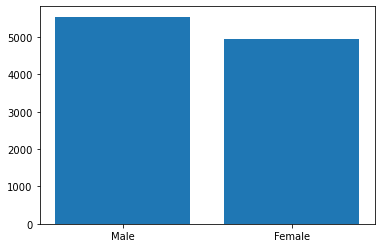

In [142]:
import matplotlib.pyplot as plt 
values = np.unique(file.gender,return_counts = True)
plt.bar(["Male","Female"], values[1])

## On the race attribute

<BarContainer object of 5 artists>

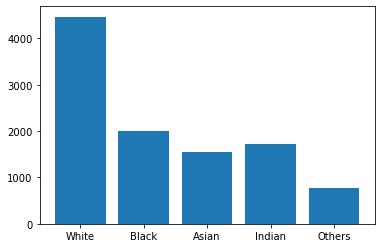

In [295]:
values = np.unique(file.race,return_counts = True)
plt.bar([ "White", "Black", "Asian", "Indian","Others"], values[1])

In [296]:
## create dataset
import torch
from torch import optim, nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from UKTFACE import UKTFace
import UKTFACE as U
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from art.attacks import FastGradientMethod
from art.classifiers import PyTorchClassifier
from art.data_generators import PyTorchDataGenerator

from art.defences import AdversarialTrainer
# switch device to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Get dataset with gender labels
uktface = UKTFace('utkface.csv', 'UTKFace', labels='gender')

# To split training, validation data
l = uktface.__len__()
training_size = int(np.ceil(l * 0.7))
validation_size = int(np.ceil(l * 0.3))
train_data, val_data = random_split(uktface, [training_size, validation_size])

# to use a data loader
train_loader = DataLoader(train_data, batch_size=10, shuffle=False)
val_loader = DataLoader(val_data, batch_size=1, shuffle=False)

## convert dataloader into datagenerator to make the wrap batch training possible
from art.data_generators import PyTorchDataGenerator
train_generator = PyTorchDataGenerator(train_loader, len(train_data), 10)

## Baseline Model

In [297]:
# set up our baseline classifier
min_pixel_value = 0
max_pixel_value = 1

model = models.resnet18(pretrained=True)
# Freeze the parameters
for param in model.parameters():
    param.requires_grad = False
    
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512, 300)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(300, 2)),
    ('output', nn.LogSoftmax(dim=1))
]))

model.fc = fc
model.to(device)

optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)
criterion = nn.NLLLoss()

classifier = PyTorchClassifier(
    model=model.train(),
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 224, 224),
    nb_classes=2,
)


## Baseline model training
classifier.fit_generator(train_generator, nb_epochs=20)
filename_pth = 'ckpt_resnet18_gender.pth'
classifier.save(filename_pth,"models")

## Storing the Result

In [298]:
import torch
stat_dic_model = torch.load('models/ckpt_resnet18_gender.pth.model')
stat_dic_opt = torch.load('models/ckpt_resnet18_gender.pth.optimizer')
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)
criterion = nn.NLLLoss()
model = models.resnet18(pretrained=True)
# Freeze the parameters
for param in model.parameters():
    param.requires_grad = False
    
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512, 300)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(300, 2)),
    ('output', nn.LogSoftmax(dim=1))
]))

model.fc = fc
model.to(device)

model.load_state_dict(stat_dic_model)
optimizer.load_state_dict(stat_dic_opt)
model.load_state_dict(stat_dic_model)
optimizer.load_state_dict(stat_dic_opt)
classifier = PyTorchClassifier(
    model=model.eval(),
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 224, 224),
    nb_classes=2,
)
# Step 5: Compare the results 
dataset = val_loader.dataset.dataset
outputs = []
race = []
expected = [] 
index = val_loader.dataset.indices
outputs_ad = []
for n, (data, label) in enumerate(val_loader):
    i = index[n]
    race.extend([dataset.get_race(i).item()])
    expected.extend(np.array(np.argmax(label,axis=1)))
    
    output=adclassifier.predict(data)
    outputs.extend(np.argmax(output, axis=1))
result = sum(np.array(outputs) == np.array(expected))/len(expected)
correct = np.array(race)[np.array(outputs) == np.array(expected)]
correct = np.unique(correct,return_counts=True)
total = np.unique(race, return_counts=True)
result_by_race=correct[1]/total[1]

## Adversarial Model
### Training

In [299]:
model2 = models.resnet18(pretrained=True)

# Freeze the parameters
for param in model2.parameters():
    param.requires_grad = False
    
model2.fc = fc
model2.to(device)

optimizerad = optim.Adam(model.fc.parameters(), lr=0.0001)
criterionad = nn.NLLLoss()

## Defence model training
classifier2 = PyTorchClassifier(
    model=model2.train(),
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterionad,
    optimizer=optimizerad,
    input_shape=(3, 224, 224),
    nb_classes=2,
)
attack = FastGradientMethod(classifier=classifier, eps=0.1)
adclassifier = AdversarialTrainer(classifier2, attack, ratio=0.5)
## Defence model training
adclassifier.fit_generator(train_generator,nb_epochs=20)
filename_pth = 'ckpt_resnet18_gender_defence.pth'
#adclassifier.classifier.save(filename_pth,"models")


### Storing the result

In [300]:
import torch
stat_dic_model_ad = torch.load('models/ckpt_resnet18_gender_defence.pth.model')
stat_dic_opt_ad = torch.load('models/ckpt_resnet18_gender_defence.pth.optimizer')
optimizer2 = optim.Adam(model.fc.parameters(), lr=0.0001)
criterion = nn.NLLLoss()
model2 = models.resnet18(pretrained=True)
# Freeze the parameters
for param in model.parameters():
    param.requires_grad = False
    
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512, 300)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(300, 2)),
    ('output', nn.LogSoftmax(dim=1))
]))

model2.fc = fc
model2.to(device)

model2.load_state_dict(stat_dic_model_ad)
optimizer2.load_state_dict(stat_dic_opt_ad)
model2.load_state_dict(stat_dic_model)
optimizer2.load_state_dict(stat_dic_opt)
adclassifier = PyTorchClassifier(
    model=model2.eval(),
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer2,
    input_shape=(3, 224, 224),
    nb_classes=2,
)
# Step 5: Compare the results 
dataset = val_loader.dataset.dataset
outputs = []
race = []
expected = [] 
index = val_loader.dataset.indices
outputs_ad = []
for n, (data, label) in enumerate(val_loader):
    i = index[n]
    race.extend([dataset.get_race(i).item()])
    expected.extend(np.array(np.argmax(label,axis=1)))
    output=adclassifier.predict(data)
    outputs.extend(np.argmax(output, axis=1))
resultad = sum(np.array(outputs) == np.array(expected))/len(expected)
correctad = np.array(race)[np.array(outputs) == np.array(expected)]
correctad = np.unique(correctad,return_counts=True)
total = np.unique(race, return_counts=True)
result_by_race_ad = correctad[1]/total[1]

In [329]:
print("Adversarial")
print("Out of sample accuracy of classification for each race")
classes = ["white", "black","asian",'indian','others']
for i in range(len(classes)):
    print("%s : %.3f"%(classes[i],result_by_race_ad[i]))

Adversarial
Out of sample accuracy of classification for each race
white : 0.809
black : 0.812
asian : 0.694
indian : 0.814
others : 0.824


In [328]:
print("Baseline")
print("Out of sample accuracy of classification for each race")
classes = ["white", "black","asian",'indian','others']
for i in range(len(classes)):
    print("%s : %.3f"%(classes[i],result_by_race[i]))

Baseline
Out of sample accuracy of classification for each race
white : 0.667
black : 0.605
asian : 0.681
indian : 0.731
others : 0.633
